In [2]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from theano.compile.ops import as_op
import theano.tensor as tt
from scipy import stats
from scipy.stats import binned_statistic
from scipy.linalg import block_diag,eigh
plt.rcParams['font.family']='stixgeneral'
plt.rcParams.update({'font.size':16})

In [80]:
#checking verison of pymc3
print('Running on PyMC3 v{}'.format(pm.__version__))
#inputting data
#data_base = np.loadtxt("Lyman_alpha_result_balout_z=3.2-3.3_testing.txt")
data_z = np.loadtxt("zratiosnr22.txt")
data_all = np.loadtxt("./jiani0126/dr14_1075-1150_co_10000_0.9_testing_snr2.2_waveflux.txt")
#data_error = np.loadtxt("test1.txt")
#covariance = np.loadtxt("test2.txt")
#gp = np.loadtxt("./jiani0126/gp_dr14_1114.txt")
data_z = data_z[:,0]
print (data_z)
i = range(0, len(data_all))
data_indi_flux = np.split(data_all[i,1], len(data_z))
data_indi_wave = np.split(data_all[i,0], len(data_z))




#picking the data from 2.8 < z < 4.8
data_indi_flux = data_indi_flux[3:]
data_indi_wave = data_indi_wave[3:]

data_z = data_z[3:]
#print (np.min(covariance_split[7]))

#using schaye metal correction + tau_lss from pyigm
data_indi_tau = [0.127+0.01,0.164+0.012,0.203+0.015,0.251+0.017,0.325+0.02]
data_redshift_base = [2.0,2.2,2.4,2.6,2.8]
data_error_base = [0.023,0.020,0.019,0.022,0.026]
data_indi_flux_final = np.append(data_indi_flux,np.array(data_indi_tau))
#data_error_final=np.append(data_error_split,np.array(data_error_base))

Running on PyMC3 v3.5
[2.54882838 2.64806702 2.7478156  2.84952959 2.95062568 3.04919773
 3.14875346 3.2480309  3.3450856  3.4461385  3.5517966  3.64821476
 3.74814819 3.84554038 3.94690707 4.08444481 4.28969931 4.49270692
 4.69101035]


In [81]:
np.savetxt("wave_0812.txt",data_indi_wave,delimiter=' ',newline='\n')
np.savetxt("flux_0812.txt",data_indi_flux,delimiter=' ',newline='\n')

In [82]:
#arranging error for the Faucher-giguere data
data_error_base = block_diag(np.array(data_error_base))
contrain_co1 = np.zeros((5,5))
indice = np.diag_indices(5)

contrain_co1[indice] = np.array(data_error_base**2)
print (contrain_co1)

[[0.000529 0.       0.       0.       0.      ]
 [0.       0.0004   0.       0.       0.      ]
 [0.       0.       0.000361 0.       0.      ]
 [0.       0.       0.       0.000484 0.      ]
 [0.       0.       0.       0.       0.000676]]


In [83]:
def converter(cov):
    #function for checking the output covariance matrix and correct the semi-positive definite matrix
    e1,v1 = np.linalg.eig(cov)
    print (np.min(e1))
    a = v1.T
    t = a@cov@a.T
    tnew = abs(t)
    return a.T@tnew@a

In [84]:
#load the covariance matrix
covtol1 = np.loadtxt("./jiani0126/dr14_1075-1150_co_10000_0.9_testing_snr2.2_tol_1.txt") 

In [85]:
#covtol = np.append(covtol1,covtol2)

covtolsplit = np.split(covtol1,19)

In [86]:
covtest= []
for ii in range(3,len(covtolsplit)):
    covtest.append(np.transpose(np.split(covtolsplit[ii],10000)))

In [87]:
final_cov = np.dot(np.vstack(covtest),np.transpose(np.vstack(covtest)))/(len(np.vstack(covtest))-1)

In [88]:
print (len(final_cov))

4512


In [89]:
# costruct the final covariance matrix
covt = []
covt.append(final_cov)
covt.append(contrain_co1)
# costruct the final covariance matrix
cov_final = block_diag(*covt)

print (np.array(cov_final))

[[ 1.52678443e-04  5.53610904e-08  2.18433544e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.53610904e-08  1.53026030e-04 -2.54346324e-07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.18433544e-06 -2.54346324e-07  1.51348380e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.61000000e-04
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   4.84000000e-04  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  6.76000000e-04]]


In [90]:
e,v = np.linalg.eig(cov_final)

In [92]:
print (len(np.ravel(np.array(data_indi_flux_final))))

4517


In [93]:

x2 = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
x2t = np.sort(np.ravel(x2))
xinter = binned_statistic(x2t[x2t<3.5],x2t[x2t<3.5],bins =8)[0]

In [94]:
print (xinter)

[2.48387246 2.61077254 2.74663414 2.88441455 3.02007663 3.15778767
 3.29364153 3.42740484]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [21]
>Slice: [20]
>Slice: [19]
>Slice: [18]
>Slice: [17]
>Slice: [16]
>Slice: [15]
>Slice: [14]
>Slice: [13]
>Slice: [12]
>Slice: [11]
>Slice: [10]
>Slice: [9]
>Slice: [8]
>Slice: [7]
>Slice: [6]
>Slice: [5]
>Slice: [4]
>Slice: [3]
>Slice: [2]
>Slice: [1]
>Slice: [0]
Sampling 2 chains: 100%|██████████| 206000/206000 [139:14:24<00:00,  4.67s/draws]   
/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conve

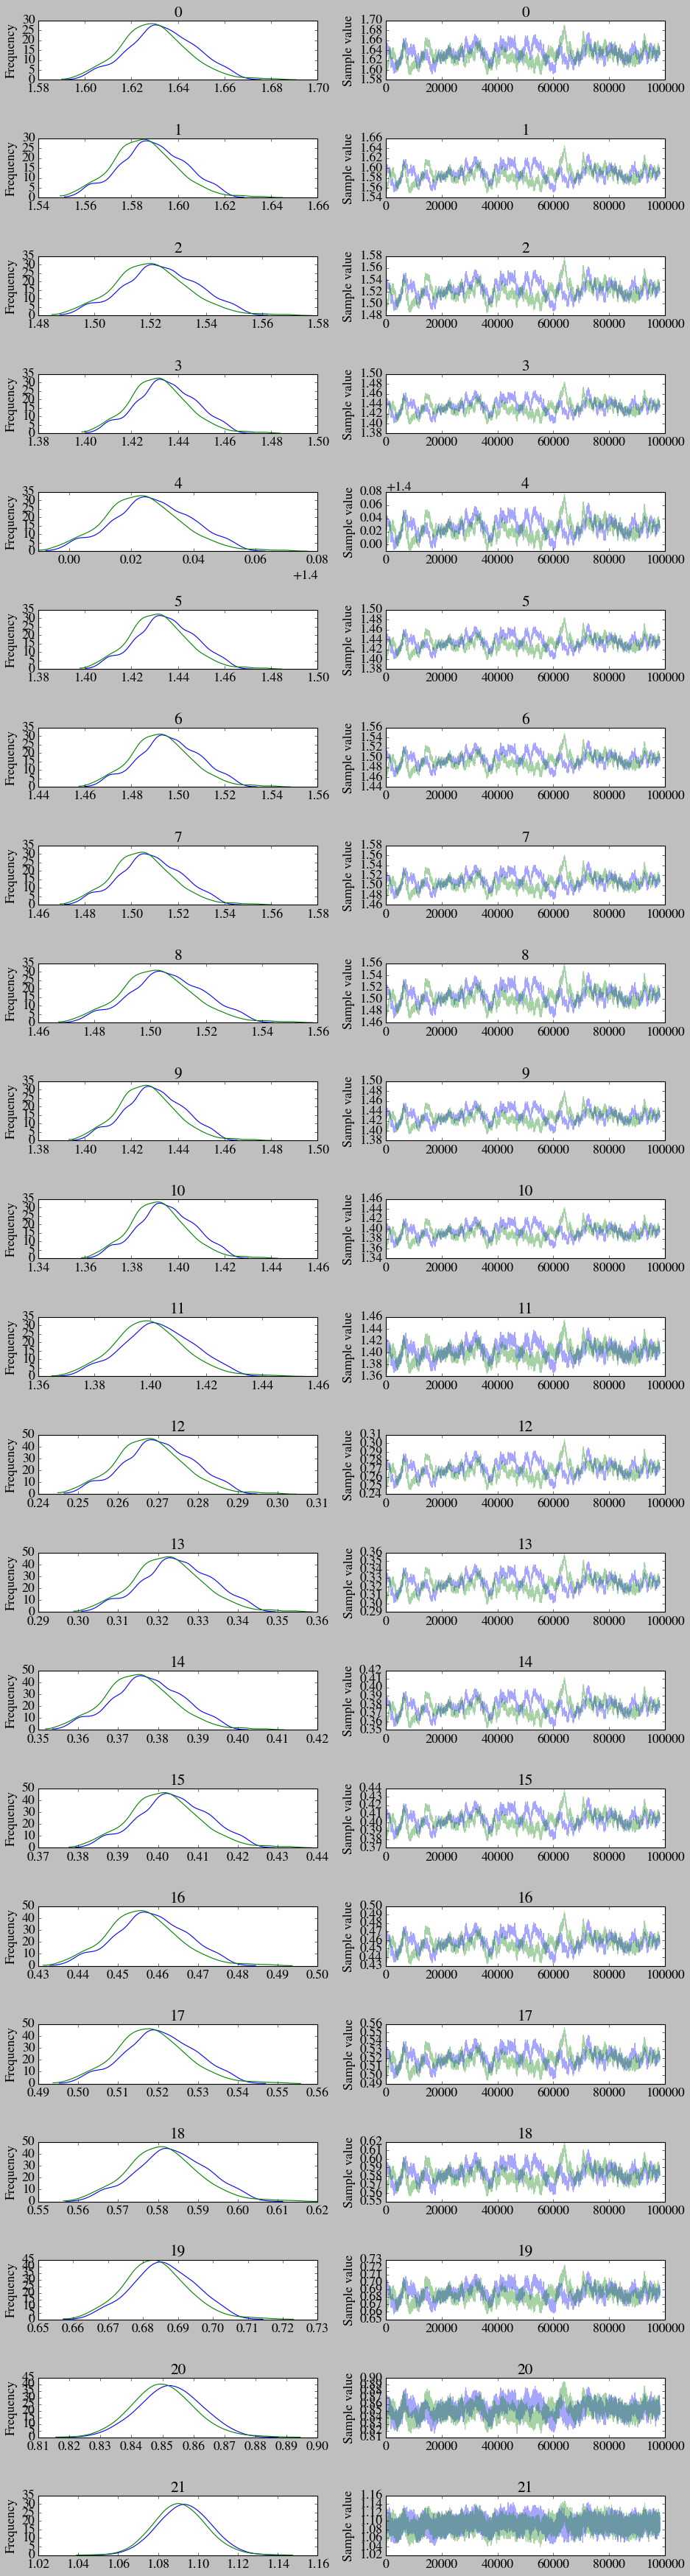

In [95]:

#begin running MCMC to find the best-fitted continuum and parameters to describe tau

n = 22
n1 = 12
n2 = n-n1


#assuming function of tau
def func(x,amp,index):
    func = amp * ((1 + x)/(1+3.05)) ** index
    return func







#setting up pymc3 model
@as_op(itypes=[tt.dscalar]*(n), otypes=[tt.dvector])
def fc(*para):
    


        #converting restframe wavelength to absorption redhsift
        #x2 = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
        #xinter = binned_statistic(np.ravel(x2),np.ravel(x2),bins = n2)[0]
        x2 = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
        x2t = np.sort(np.ravel(x2))
        xinterl = binned_statistic(x2t[x2t<3.5],x2t[x2t<3.5],bins = n2-3)[0]
        xinterh = binned_statistic(x2t[x2t>3.5],x2t[x2t>3.5],bins = 3)[0]
        xinter = np.append(xinterl,xinterh)
        tau= interp1d(xinter,para[n1:n],fill_value = 'extrapolate')
        tau_1=tau(x2)
        #print (xinter)
        #wavelength for continuum model
        xi = np.linspace(data_indi_wave[5][0], data_indi_wave[5][len(data_indi_wave[5])- 1], n1)
        
        result_final = interp1d(xi, np.array(para[:n1]), kind='cubic')(data_indi_wave[5])*np.exp(-np.array(tau_1))
      
        #adding the constraint from Faucher2008
        x1 = np.array(data_redshift_base)
        #print (result_final)
        result_final1= np.append(result_final,tau(x1))
        

        return np.ravel(result_final1)


if __name__ == '__main__':
    with pm.Model() as model:
        #the prior distribution of all the parameters
        para = []
        n = 22
        n1 = 12
        n2 = n-n1
        k1 = 0.18
        for i in range(0,n1):
            para.append(pm.Uniform(str(i), 0.6, 2.8))
        for i in range(n1,n):
            para.append(pm.Uniform(str(i), k1, k1+0.6))
            k1=k1+0.045
        #print (para)

        fc = fc(*para)
        #fit the model to observed data
        pymc_data = pm.MvNormal(str('output_data'), mu=fc, cov =  np.array(cov_final), observed=np.ravel(np.array(data_indi_flux_final)))

        trace = pm.sample(98000,burn=6000,tune=5000, chain=2, cores=2)

pm.traceplot(trace)
plt.show()


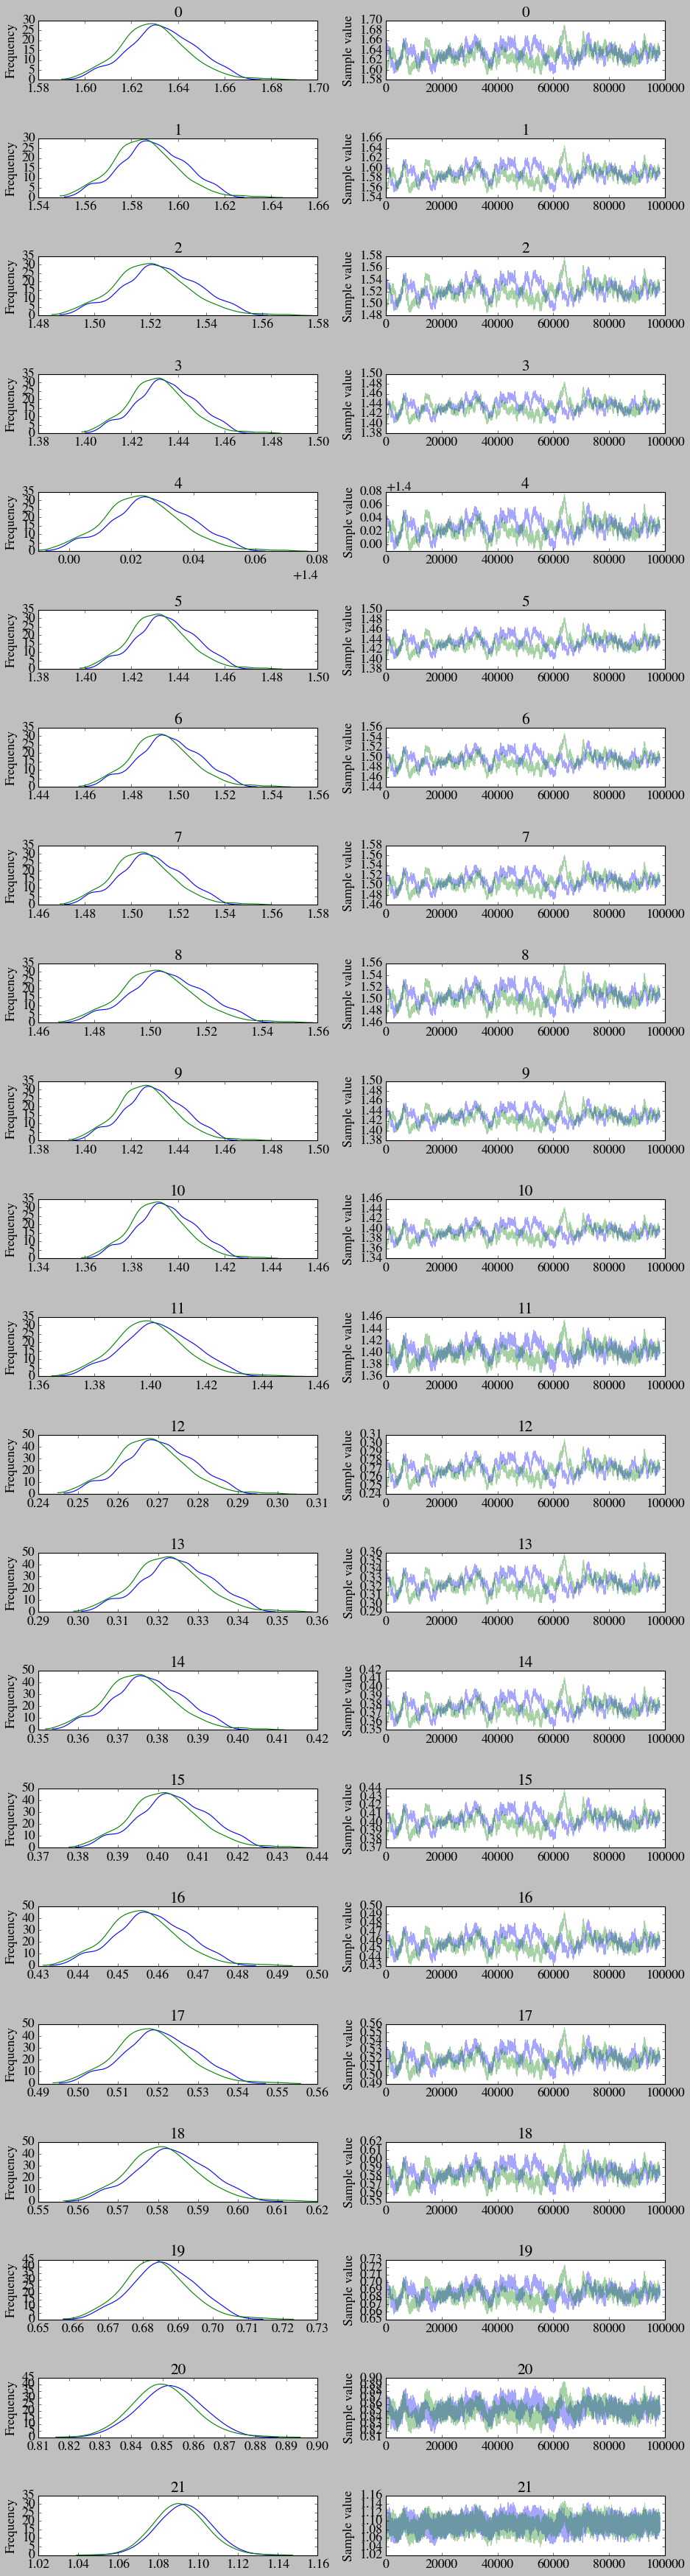

In [100]:
#plotting and saving the traces
pm.traceplot(trace)

#plt.savefig('trace0826.pdf')

plt.show()

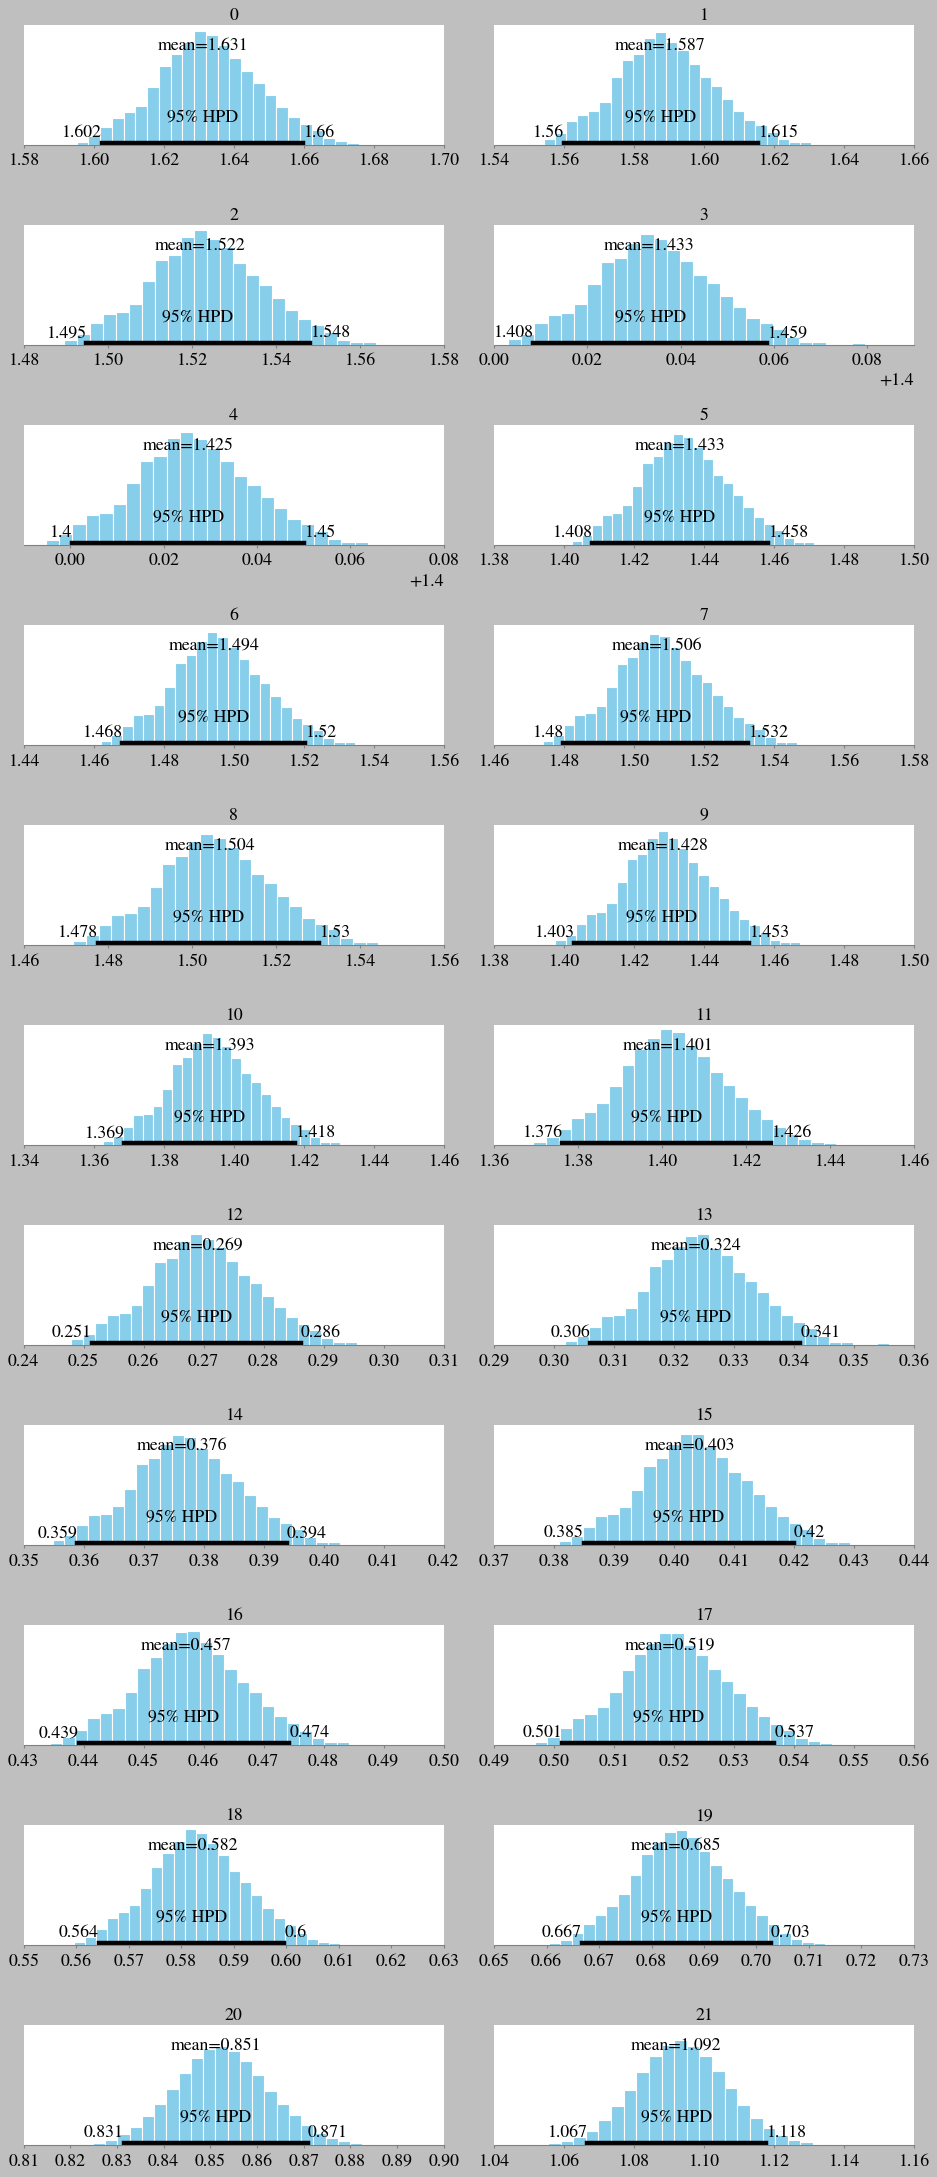

In [101]:
#plotting the posterior

pm.plot_posterior(trace)
plt.savefig('trace0807.png',dpi=600)
plt.show()

In [102]:
from pymc3 import summary

summary(trace)

/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
0   1.631358  0.014675  0.001229  1.602245  1.659724   68.115378  1.015064
1   1.587381  0.014175  0.001197  1.559875  1.615355   66.996617  1.015489
2   1.522145  0.013595  0.001148  1.494913  1.548118   67.103300  1.015391
3   1.433275  0.012816  0.001081  1.408387  1.458554   67.189382  1.015297
4   1.425194  0.012746  0.001075  1.400330  1.450172   67.203937  1.015412
5   1.433147  0.012824  0.001082  1.407961  1.458166   67.238107  1.015334
6   1.494491  0.013371  0.001128  1.468024  1.520364   67.101949  1.015399
7   1.506456  0.013484  0.001137  1.479696  1.532495   67.252743  1.015345
8   1.504351  0.013470  0.001136  1.477618  1.530394   67.190325  1.015304
9   1.428235  0.012790  0.001079  1.402855  1.452935   67.177929  1.015416
10  1.393186  0.012481  0.001053  1.368636  1.417506   67.144782  1.015423
11  1.401350  0.012718  0.001058  1.376279  1.425982   69.197529  1.014746
12  0.269049  0.008885  0.000751  0.251368  0.286178   66.871185  1.015445
13  0.323708  0.008949  0.000756  0.306029  0.341084   66.940365  1.015418
14  0.376354  0.008921  0.000754  0.358918  0.393820   66.926751  1.015469
15  0.402698  0.008946  0.000755  0.384950  0.420021   67.118479  1.015437
16  0.457069  0.008964  0.000754  0.439176  0.474254   67.372031  1.015330
17  0.519311  0.008996  0.000755  0.501395  0.536726   67.933448  1.015252
18  0.582262  0.009033  0.000754  0.564257  0.599634   68.488600  1.015056
19  0.684700  0.009191  0.000755  0.666729  0.702746   70.726873  1.014667
20  0.851293  0.010047  0.000755  0.831394  0.870875   83.999801  1.012150
21  1.091899  0.013032  0.000754  1.066672  1.117797  142.839784  1.007131

{'0': 1.0150642451290424, '1': 1.0154886981195628, '2': 1.015391496513989, '3': 1.0152972890645802, '4': 1.0154116979650891, '5': 1.0153340877741064, '6': 1.0153986058082325, '7': 1.015344537423882, '8': 1.0153043105284283, '9': 1.015415792042312, '10': 1.0154228461745365, '11': 1.014746422065126, '12': 1.0154449930966454, '13': 1.0154178353843626, '14': 1.015469293942772, '15': 1.015437226132246, '16': 1.015330006280378, '17': 1.0152522642121098, '18': 1.015056299271943, '19': 1.014666981256082, '20': 1.012150470043834, '21': 1.007131180474399}


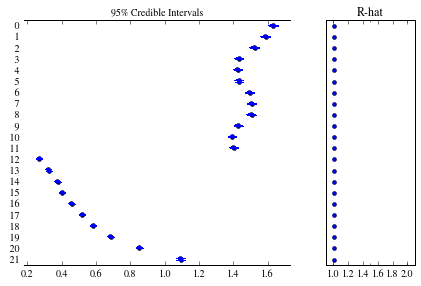

In [107]:
%matplotlib inline  
from pymc3 import forestplot
from pymc3 import gelman_rubin
from pymc3 import quantiles
print (gelman_rubin(trace))

forestplot(trace)

In [109]:
summary(trace)

/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
0   1.631358  0.014675  0.001229  1.602245  1.659724   68.115378  1.015064
1   1.587381  0.014175  0.001197  1.559875  1.615355   66.996617  1.015489
2   1.522145  0.013595  0.001148  1.494913  1.548118   67.103300  1.015391
3   1.433275  0.012816  0.001081  1.408387  1.458554   67.189382  1.015297
4   1.425194  0.012746  0.001075  1.400330  1.450172   67.203937  1.015412
5   1.433147  0.012824  0.001082  1.407961  1.458166   67.238107  1.015334
6   1.494491  0.013371  0.001128  1.468024  1.520364   67.101949  1.015399
7   1.506456  0.013484  0.001137  1.479696  1.532495   67.252743  1.015345
8   1.504351  0.013470  0.001136  1.477618  1.530394   67.190325  1.015304
9   1.428235  0.012790  0.001079  1.402855  1.452935   67.177929  1.015416
10  1.393186  0.012481  0.001053  1.368636  1.417506   67.144782  1.015423
11  1.401350  0.012718  0.001058  1.376279  1.425982   69.197529  1.014746
12  0.269049  0.008885  0.000751  0.251368  0.286178   66.871185  1.015445
13  0.323708  0.008949  0.000756  0.306029  0.341084   66.940365  1.015418
14  0.376354  0.008921  0.000754  0.358918  0.393820   66.926751  1.015469
15  0.402698  0.008946  0.000755  0.384950  0.420021   67.118479  1.015437
16  0.457069  0.008964  0.000754  0.439176  0.474254   67.372031  1.015330
17  0.519311  0.008996  0.000755  0.501395  0.536726   67.933448  1.015252
18  0.582262  0.009033  0.000754  0.564257  0.599634   68.488600  1.015056
19  0.684700  0.009191  0.000755  0.666729  0.702746   70.726873  1.014667
20  0.851293  0.010047  0.000755  0.831394  0.870875   83.999801  1.012150
21  1.091899  0.013032  0.000754  1.066672  1.117797  142.839784  1.007131

In [113]:
#plotting the difference between mean model and the data
#model inspection

def plot_MCMC_model(n,xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    n=n
    n1=12
    n2=n-n1
    
    mean = []
    ylow =[]
    yup =[]
    for i in range(0,n):
        mean.append(summary(trace)['mean'][i])
        ylow.append(summary(trace)['hpd_2.5'][i])
        yup.append(summary(trace)['hpd_97.5'][i]) 

    x2 = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
    x2t = np.sort(np.ravel(x2))
    xinterl = binned_statistic(x2t[x2t<3.5],x2t[x2t<3.5],bins = n2-3)[0]
    xinterh = binned_statistic(x2t[x2t>3.5],x2t[x2t>3.5],bins = 3)[0]
    xinter = np.append(xinterl,xinterh)
    tau= interp1d(xinter,mean[n1:n],fill_value = 'extrapolate')
    tau_1=tau(x2)
        
        #wavelength for continuum model
    xi = np.linspace(data_indi_wave[5][0], data_indi_wave[5][len(data_indi_wave[5])- 1], n1)
    result_final = interp1d(xi, np.array(mean[:n1]), kind='cubic')(data_indi_wave[5])*np.exp(-np.array(tau_1))
   
    result_final1 = interp1d(xi, np.array(ylow[:n1]), kind='cubic')(data_indi_wave[5])*np.exp(-np.array(tau_1))
    result_final2 = interp1d(xi, np.array(yup[:n1]), kind='cubic')(data_indi_wave[5])*np.exp(-np.array(tau_1))
        #adding the constraint from Faucher2008
    x1 = np.array(data_redshift_base)
        #print (result_final)
    result_model= np.append(result_final,tau(x1))
    result_model1 = np.append(result_final1,tau(x1))
    result_model2 = np.append(result_final2,tau(x1))
        
        

    
    fig, ax = plt.subplots(3, 2, figsize=(18, 20), gridspec_kw={'wspace': 0.15, 'hspace': 0.2}, sharex=False, sharey=False)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    k = 0
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, ydata[k], label=r'z_{c}='+str('{:.2f}'.format(data_z[k])) + ' Composite')
            #ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, result_model[k*282:(k+1)*282], label='model')
            ax[index][jndex].fill_between(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, result_model1[k*282:(k+1)*282], result_model2[k*282:(k+1)*282], color='red',alpha=0.5,label = 'Model 95% Confidence Level')
       
            ax[index][jndex].set_xlabel('redshift')
            ax[index][jndex].set_ylabel('flux')
            ax[index][jndex].legend( prop={'size': 20})
        
            
            
            k = k + 1
            
    
    
   # plt.savefig('model_fittednew_high_0826.pdf')
    
    plt.show()
    plt.plot(data_redshift_base,tau(x1),label = 'Model 95% Confidence Level')
    plt.plot(data_redshift_base,data_indi_tau,label = 'DR14 Composite')
    plt.errorbar(data_redshift_base,data_indi_tau,yerr=np.array([0.018,0.013,0.009,0.01,0.012]),capsize = 2.0,label = 'faucher2008 data')
    plt.savefig('model_fitted4.png')
    plt.show()
    
    
   # plt.fill_between(xdata, mu - sig, mu + sig, color='lightgray')
    
    

    return  xi,xinter,result_model1,tau_1,tau, interp1d(xi, np.array(mean[:n1]), kind='cubic')(data_indi_wave[5])

/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/home/jding/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


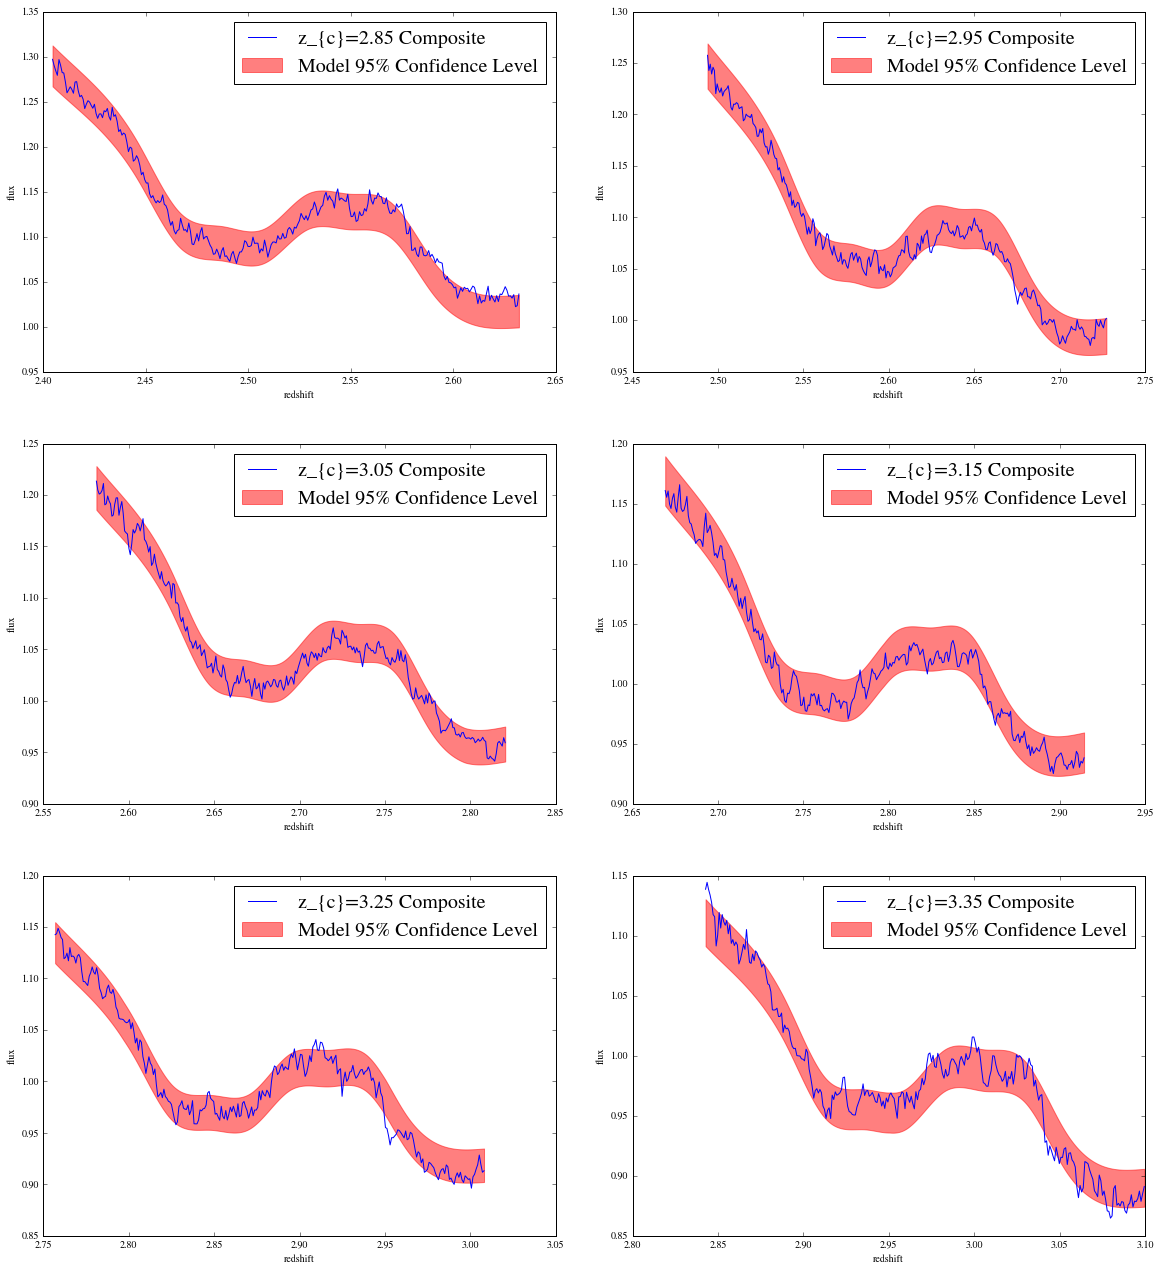

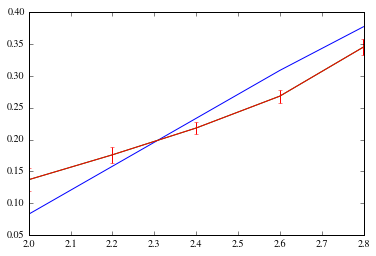

In [115]:
xcon,xtau,model,taut,tau,conti = plot_MCMC_model(22,data_indi_wave, data_indi_flux, trace)

In [116]:
#saving the continuum function
np.savetxt("conti_model_new_1125_metal_0902",conti, delimiter = " ", newline = '\n')

In [120]:
#saving the continuum function
np.savetxt("tau_model_new_0320_metal_0902",taut,delimiter = " ", newline = '\n')

In [121]:
np.savetxt("taux_model_new_1125_metal_0902",xtau,delimiter = " ", newline = '\n')

In [122]:
np.savetxt("conx_model_new_1125_metal_0902",xcon,delimiter = " ", newline = '\n')

In [123]:
def deltaalpha_plot(conti,xdata,dataflux,ref,data_zf):
    #plotting delta tau
    
    x2 = np.array(xdata) / np.array(1215.67 / (1+np.array(np.split(data_zf, len(data_zf))))) - 1
    tau = -np.log(np.array(dataflux)/conti)
    xalpha = np.ravel(x2)
    tautotal = np.ravel(tau)
    deltatau = tautotal - np.mean(tautotal[np.where((ref-0.005 < xalpha)&(xalpha< ref+0.005))])
    print (np.mean(tautotal[np.where((ref-0.005 < xalpha)&(xalpha< ref+0.005))]))
    
    plt.figure(figsize=(13,12))
    plt.scatter(xalpha[:6000],deltatau[:6000],s=3)
    #plt.xlim(0,2.8)
    plt.xlabel('zalpha')
    plt.ylabel('deltatau')
    #plt.savefig('/Users/Jenny/desktop/deltaualpha_new.png')
    plt.show()
    return xalpha,tautotal,deltatau

0.374197994044045


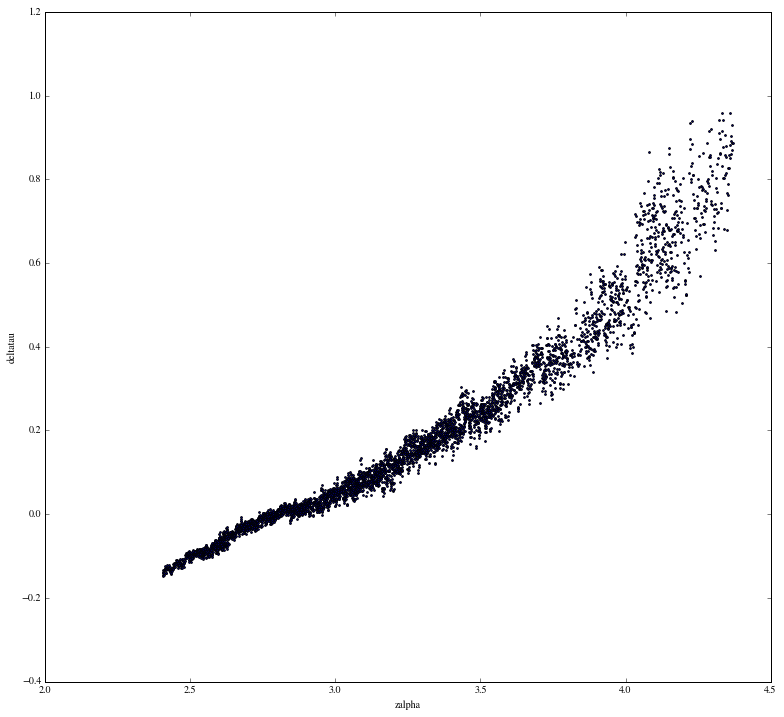

In [124]:
xalpha,tauf,deltatau = deltaalpha_plot(conti,data_indi_wave,data_indi_flux,2.8,data_z)

In [65]:
#creating corner plot to investigate the correlation between the two parameters fitted in MCMC

import corner
def corner_plot(n,trace):
    cornerplot = []
    names = []
    for ii in range(0,n):
        cornerplot.append(trace.get_values(str(ii),burn = 10000//2,combine=True))
        names.append(str(ii))
 
    #adding data from the traces

    

    
    figure = corner.corner(np.transpose(np.vstack(np.array(cornerplot))).reshape(len(cornerplot[0]),n),labels=[*names],show_titles=True, title_kwargs={"fontsize": 25},title_fmt = '.3f', quantiles = [0.32,0.5,0.68])
    plt.savefig('Corner_plot_7-12.pdf')
    plt.show()
    
   
    
    
    return cornerplot



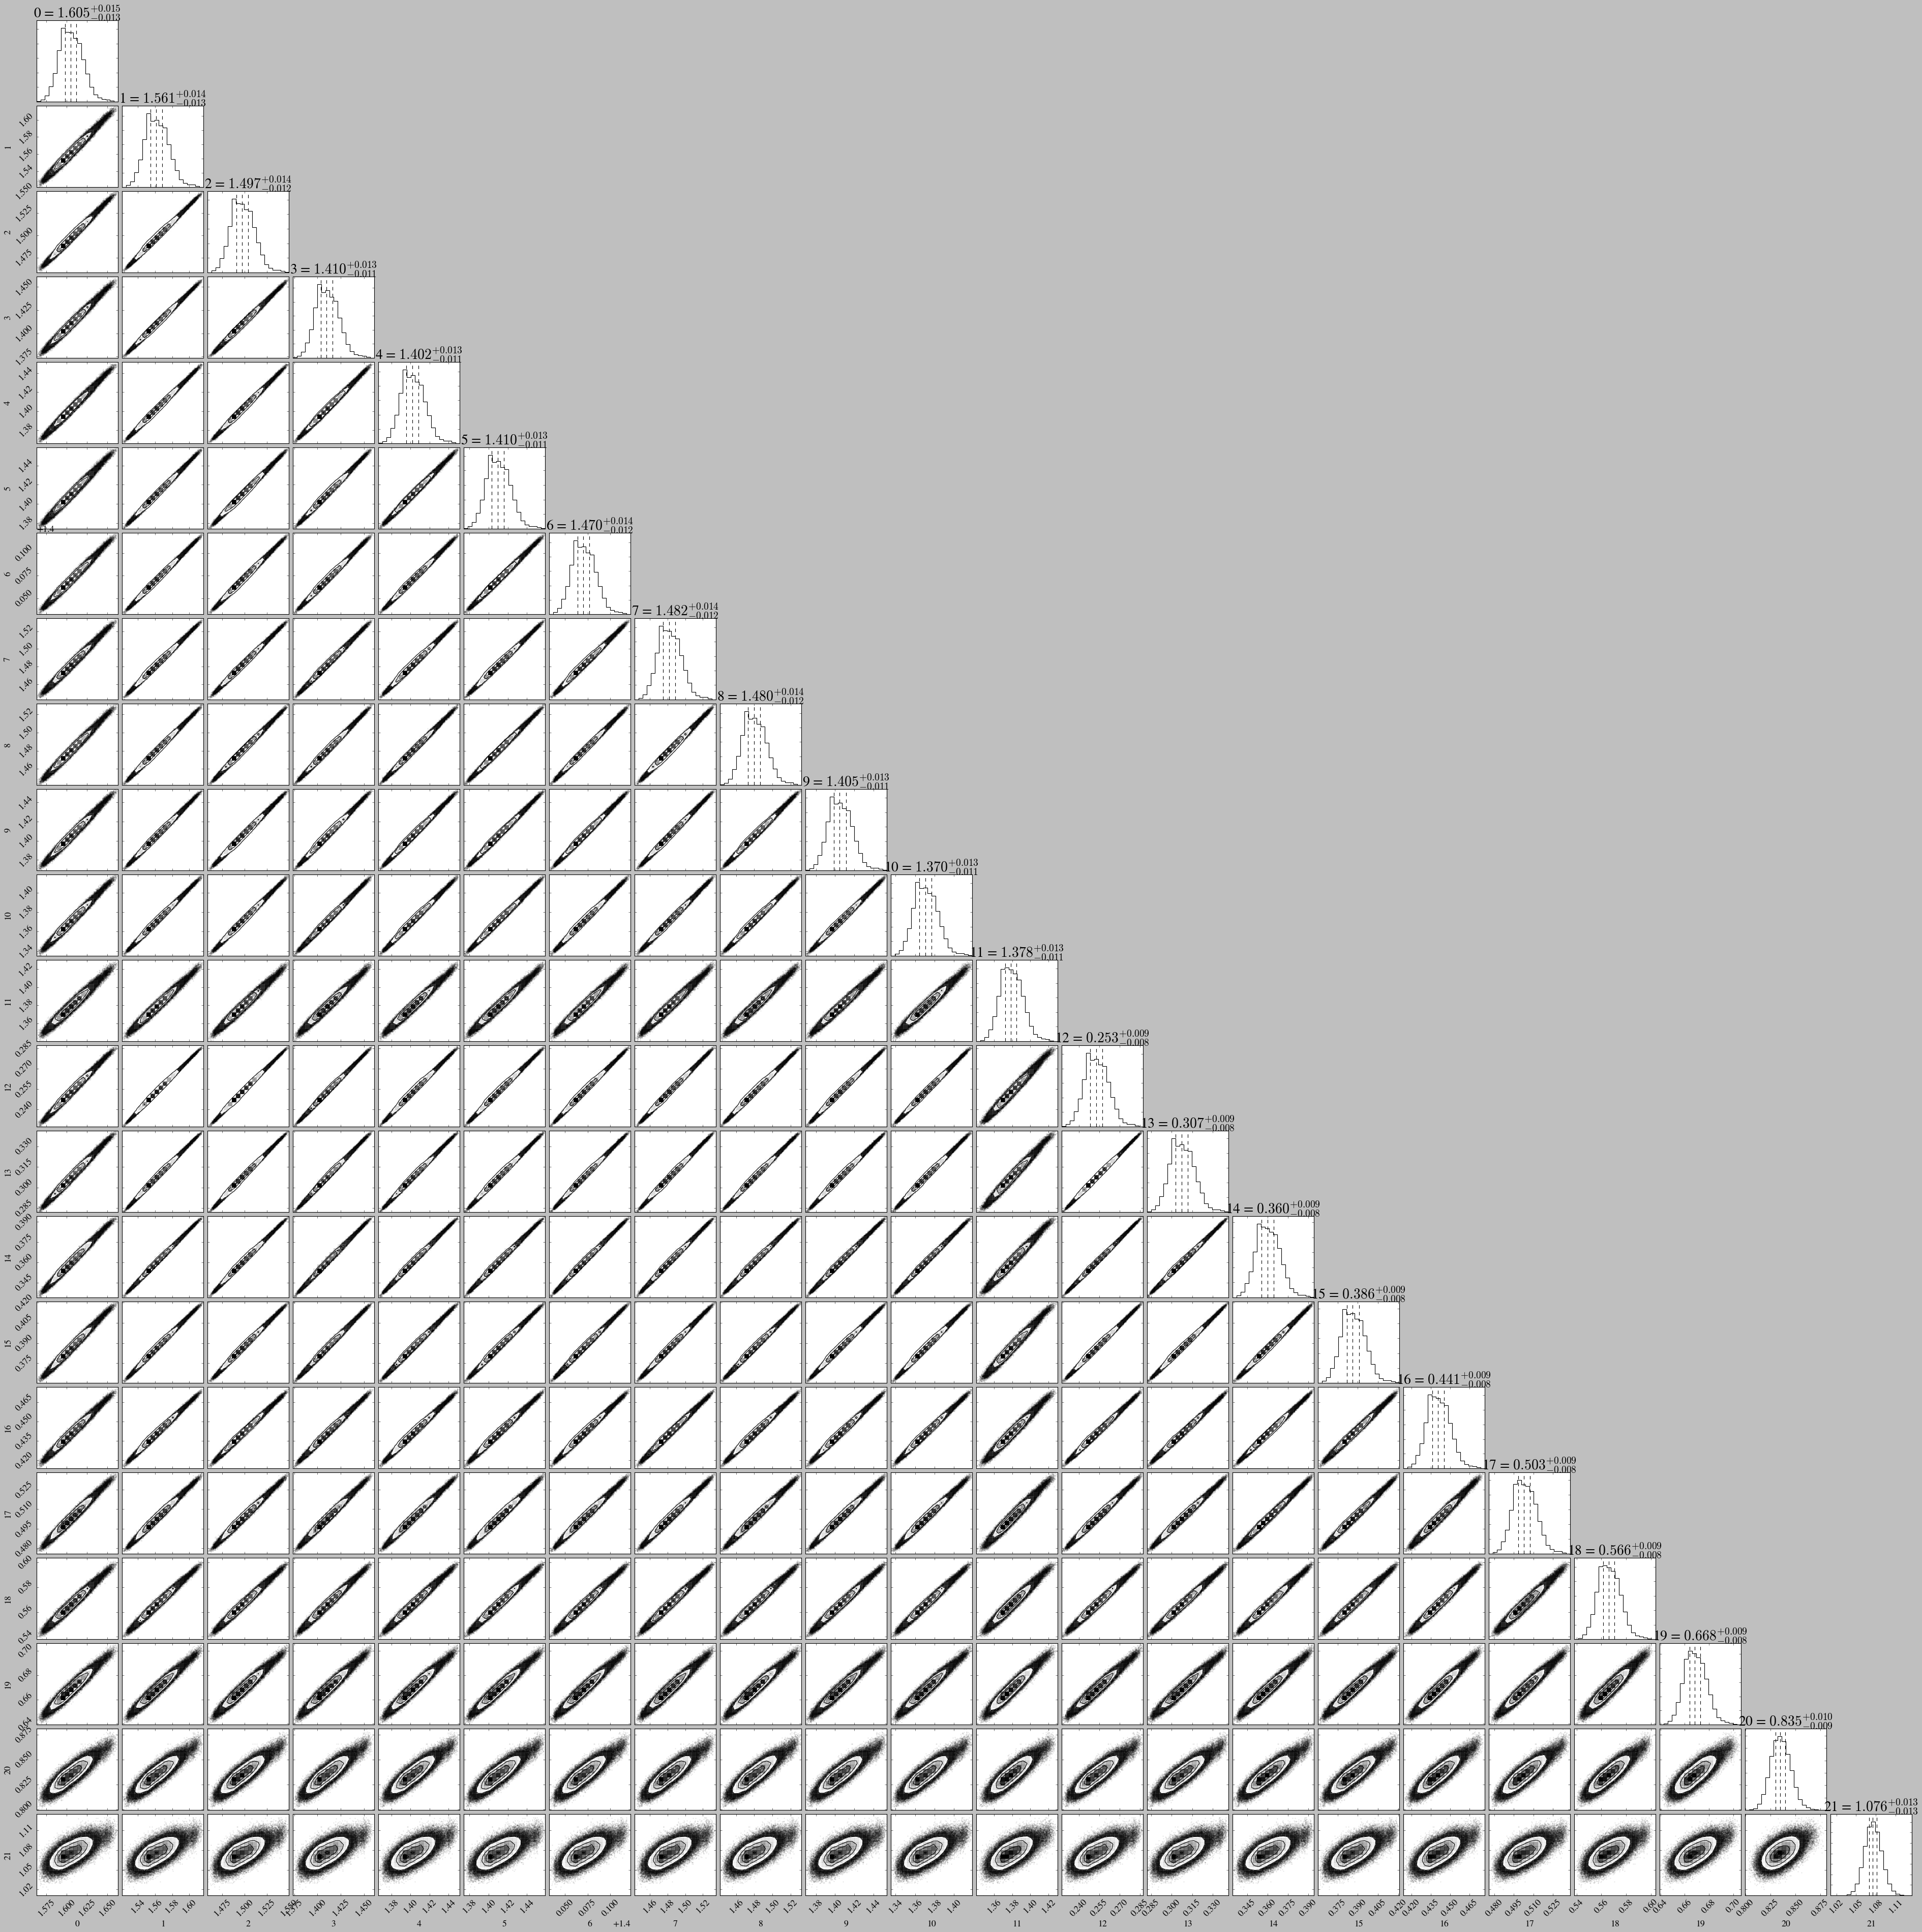

In [66]:
cornerplot = corner_plot(22,trace)

In [76]:
df.to_csv('cornerplot.csv',index=False)